In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import tensorflow as tf
import h5py, os, yaml
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from tqdm import tqdm
import glob
import pandas as pd
import subprocess
import itertools
import tfr_evaluate, util
import explain
import embed
import metrics
import quant_GIA
from test_to_bw_fast import read_model, get_config


In [2]:
motif_dict = {'..GATAA..': 'GATA', 
             '..TGA.TCA..':'AP-1',
             '..GAGAG..':'Trl',
             '..CATCTG..':'twist',
             '..ATCGAT..': 'Dref'}

model_dict = {'add_GIA_interaction/run-20211019_161849-9ygdmjss':'mod_binary',
             'add_GIA_interaction/run-20210825_040148-nieq47kf': 'basset',
             'add_GIA_interaction/run-20211023_095131-w6okxt01': '32_new'}
result_dirs = glob.glob('add_GIA_interaction/*')
result_dirs

['add_GIA_interaction/run-20211019_161849-9ygdmjss',
 'add_GIA_interaction/run-20210825_040148-nieq47kf',
 'add_GIA_interaction/run-20211023_095131-w6okxt01']

In [63]:
cell_spec_res = []
for result_dir in result_dirs:
    model_name = model_dict[result_dir]
    all_motif_pairs = set([''.join(d.split('_')[1:]) for d in os.listdir(result_dir) if '_and_' in d])
    for motifs in tqdm(list(all_motif_pairs)):
        
        for cell_line in list(set([f.split('_')[0] for f in os.listdir(result_dir)])):
            motif1, motif2 = motifs.split('and')
            motif_res_path = os.path.join(result_dir, '{}_{}'.format(cell_line, '_and_'.join([motif1, motif2])))
            int_df = pd.read_csv(os.path.join(motif_res_path, '1024_best_distance_interaction.csv')).iloc[:,1:]
            motif_names = []
            m1 = [m for m in int_df['motif'].values if all([k in m for k in motif1.strip('.').split('.')])][0]
            m2 = [m for m in int_df['motif'].values if all([k in m for k in motif2.strip('.').split('.')])][0]
            m1_df = int_df[int_df['motif'] == m1]
            sum_diffs = m1_df['mean difference'].values + int_df[int_df['motif'] == m2]['mean difference'].values
            df = pd.DataFrame()
            df['mean difference'] = sum_diffs
            df['cell line'] = m1_df['cell line'].values
            df['motif'] = 'sum'
            df['added motif'] = 'sum'
            int_df = pd.concat([int_df, df])
            for m in int_df['motif'].values:
                motif_names.append(m.replace(m1, motif_dict[motif1]).replace(m2, motif_dict[motif2]))
            int_df['added motif'] = motif_names
            int_df['model'] = model_name
            pair_name = [m for m in motif_names if '&' in m][0]
            int_df['motif'] = pair_name.replace(' ', '_')
            cell_spec_res.append(int_df[int_df['cell line'] == cell_line])
            

100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause diff

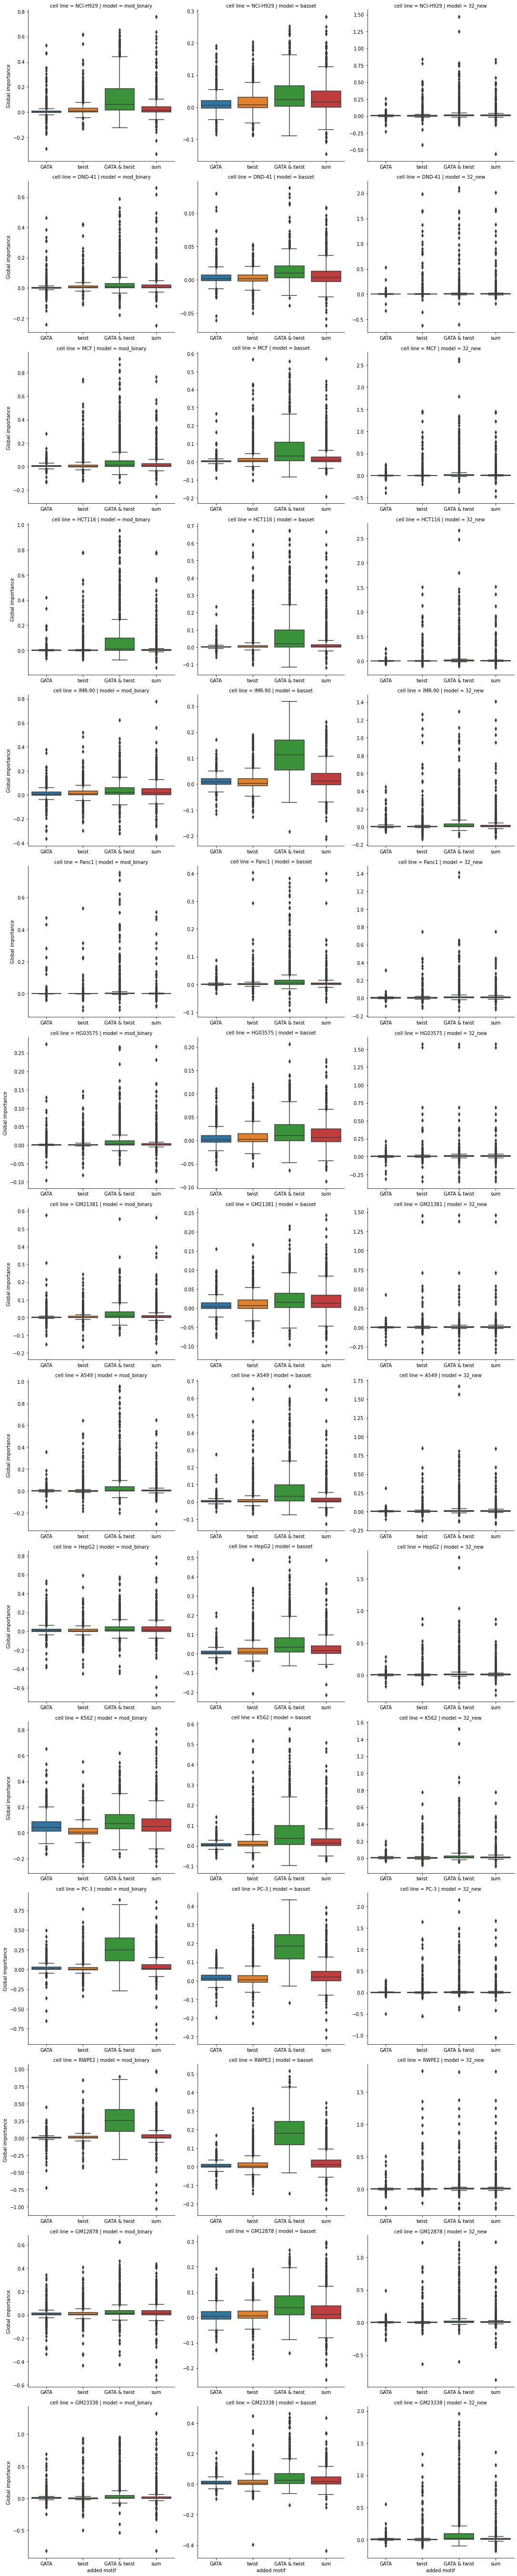

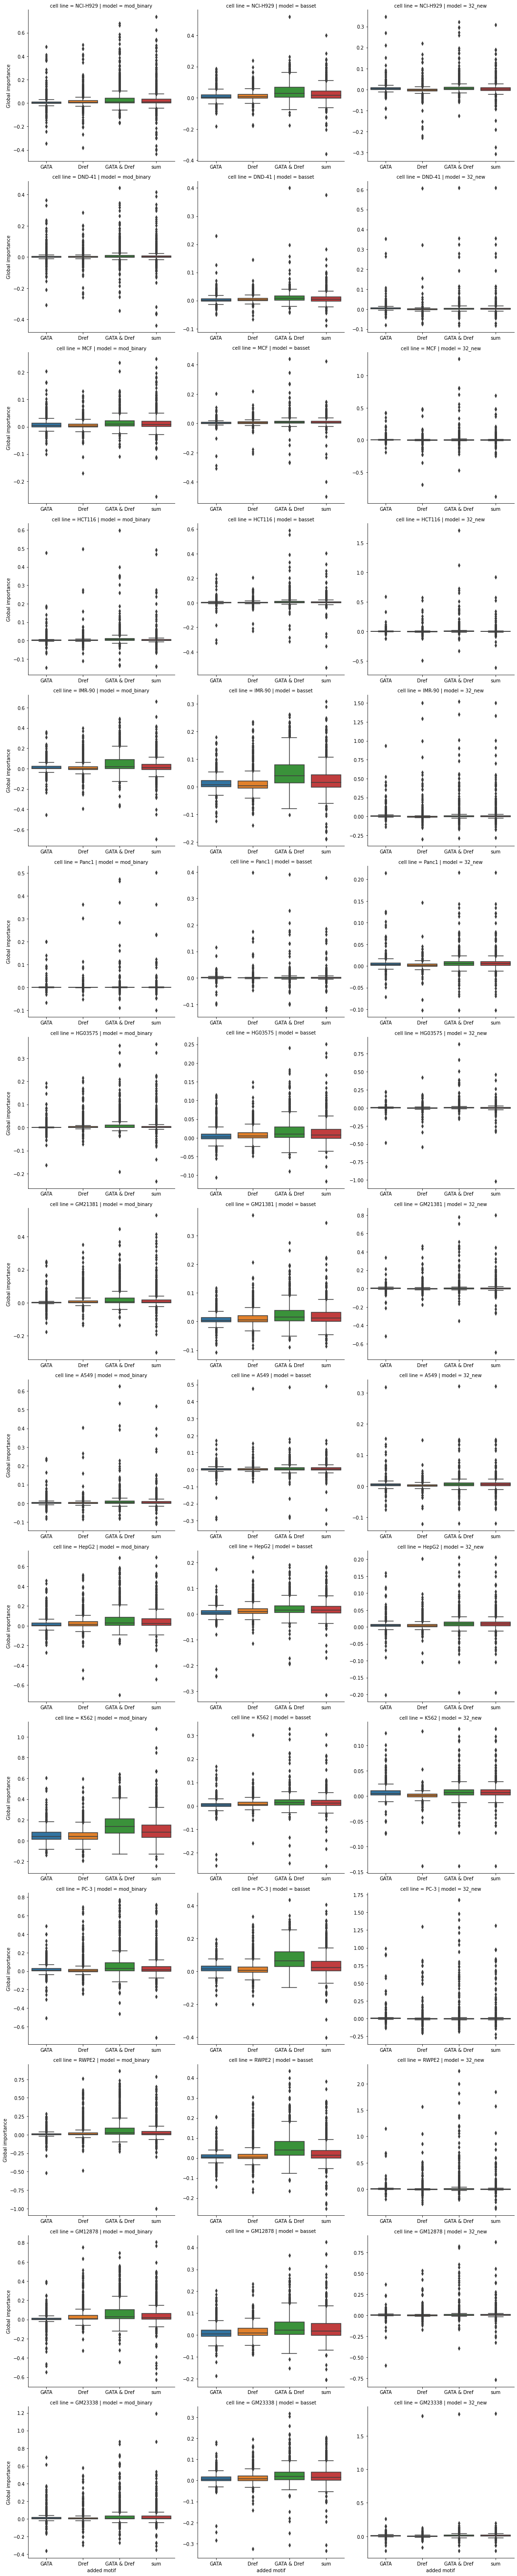

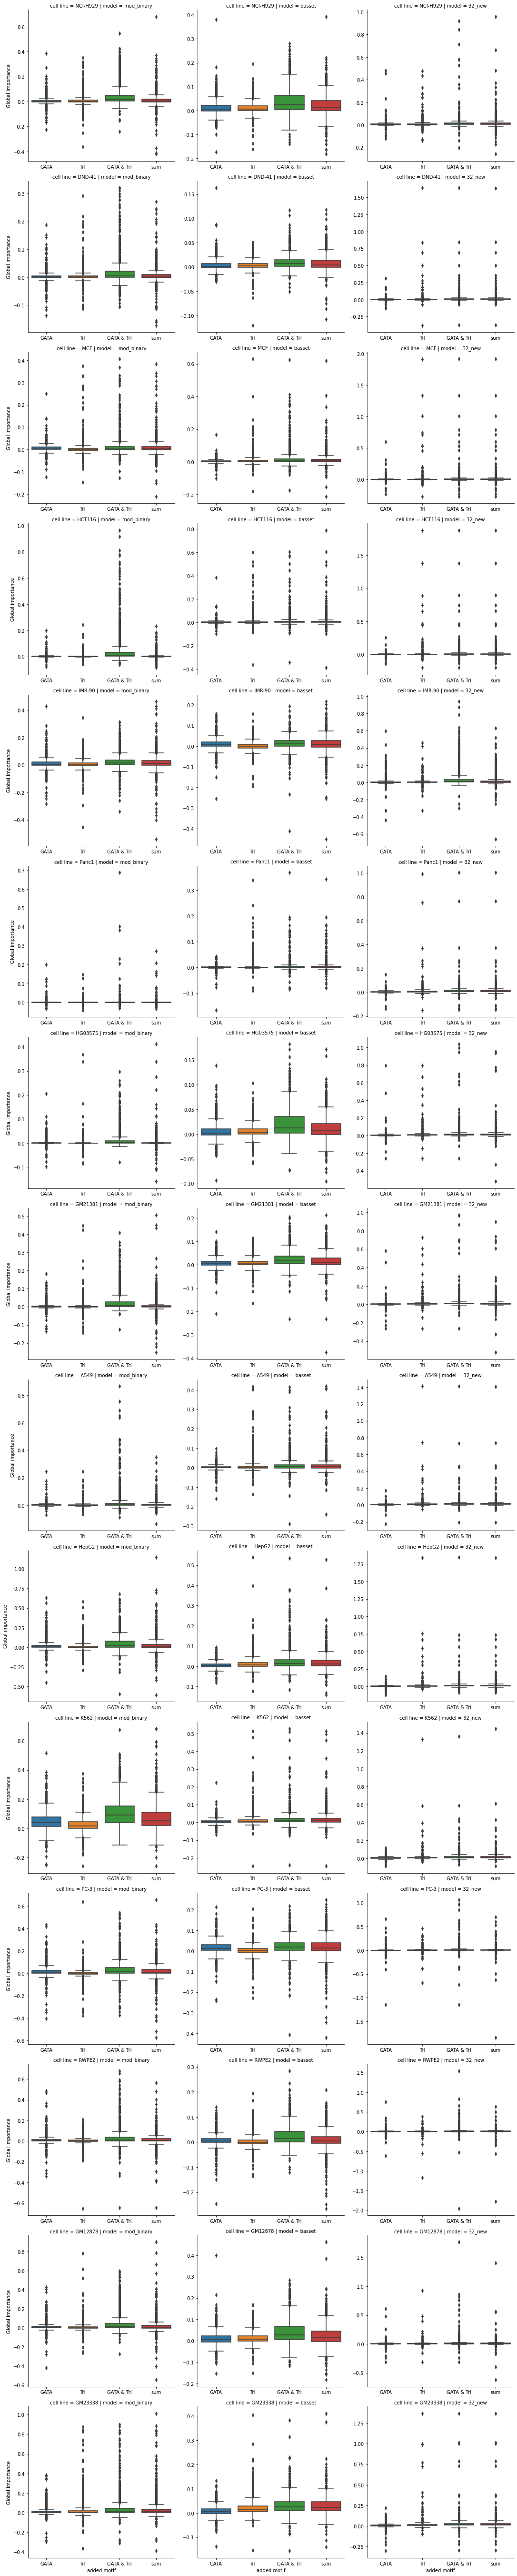

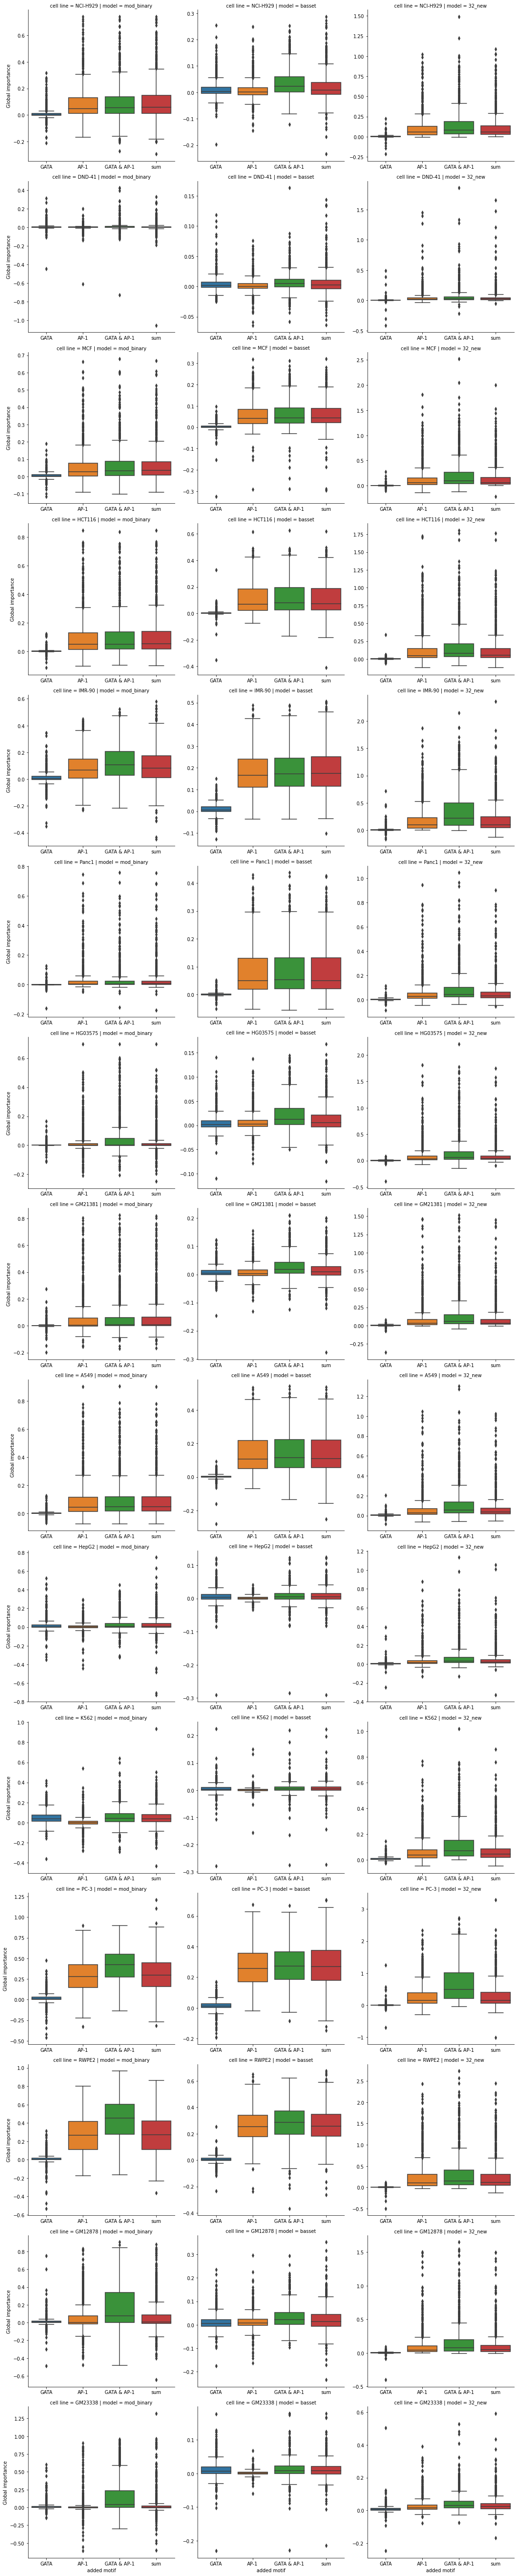

In [82]:
plot_dir = util.make_dir('add_GIA_interaction_plots')
df = pd.concat(cell_spec_res)
df = df.rename(columns={'mean difference':'Global importance'})
for motif in set(df['motif'].values):
    sns.catplot(data=df[df['motif']==motif], x='added motif', 
                y='Global importance', row='cell line',
                col='model', kind='box', sharey=False,
               sharex=False)
    plt.savefig(os.path.join(plot_dir, '{}.svg'.format(motif)))
# plt.suptitle('{} in {} moxsxdel'.format([m for m in motif_names if '&' in m][0], model_name), x=0.5, y=1.05, fontweight="bold", fontsize=16)


In [92]:
sns.scatterplot(dist_df)

,motif 2,mean difference,cell line,motif 1
0,GATGACTCATC_0,-0.000107,GM21381,ATGATAAAT_1024
1,GATGACTCATC_0,0.017541,GM23338,ATGATAAAT_1024
2,GATGACTCATC_0,0.008312,HepG2,ATGATAAAT_1024
3,GATGACTCATC_0,0.025075,RWPE2,ATGATAAAT_1024
4,GATGACTCATC_0,-0.001023,HG03575,ATGATAAAT_1024
...,...,...,...,...
15280,GATGACTCATC_2036,0.010463,IMR-90,ATGATAAAT_1024
15281,GATGACTCATC_2036,0.003982,NCI-H929,ATGATAAAT_1024
15282,GATGACTCATC_2036,0.001230,Panc1,ATGATAAAT_1024
15283,GATGACTCATC_2036,0.015536,PC-3,ATGATAAAT_1024


In [8]:
df

,motif 2,mean difference,cell line,motif 1
0,AAGATAAAC_0,0.097409,GM21381,GATGACTCATA_1024
1,AAGATAAAC_0,0.019183,GM23338,GATGACTCATA_1024
2,AAGATAAAC_0,0.032682,HepG2,GATGACTCATA_1024
3,AAGATAAAC_0,0.254672,RWPE2,GATGACTCATA_1024
4,AAGATAAAC_0,0.107237,HG03575,GATGACTCATA_1024
...,...,...,...,...
15295,AAGATAAAC_2038,0.190793,IMR-90,GATGACTCATA_1024
15296,AAGATAAAC_2038,0.112826,NCI-H929,GATGACTCATA_1024
15297,AAGATAAAC_2038,0.054377,Panc1,GATGACTCATA_1024
15298,AAGATAAAC_2038,0.293862,PC-3,GATGACTCATA_1024


In [122]:
dist_dfs = []
for cell in ['PC-3']:
    df = pd.read_csv('add_GIA_interaction/run-20211023_095131-w6okxt01/{}_..TGA.TCA.._and_..ATAAA../dinuc_N1000/1024_distance.csv'.format(cell))
    df['insertion position'] = [int(d.split('_')[1]) for d in df['motif 2']]
    dist_dfs.append(df[df['cell line']==cell])
dist_dfs = pd.concat(dist_dfs).reset_index()



In [123]:
pos = dist_dfs['insertion position'].values


In [124]:
np.argwhere((pos>1023)&(pos<1024+7)).flatten()

array([512, 513, 514, 515])

In [125]:
for p in np.argwhere((pos>1023)&(pos<1024+7)).flatten():
    dist_dfs.iloc[p, 2] = np.nan

In [126]:
dist_dfs[dist_dfs['insertion position']>1018]

,index,motif 2,mean difference,cell line,motif 1,insertion position
510,7663,AAATAAACA_1020,0.027005,PC-3,TATGAGTCATC_1024,1020
511,7678,AAATAAACA_1022,0.006955,PC-3,TATGAGTCATC_1024,1022
512,7693,AAATAAACA_1024,NaN,PC-3,TATGAGTCATC_1024,1024
513,7708,AAATAAACA_1026,NaN,PC-3,TATGAGTCATC_1024,1026
514,7723,AAATAAACA_1028,NaN,PC-3,TATGAGTCATC_1024,1028
...,...,...,...,...,...,...
1015,15238,AAATAAACA_2030,0.295353,PC-3,TATGAGTCATC_1024,2030
1016,15253,AAATAAACA_2032,0.293632,PC-3,TATGAGTCATC_1024,2032
1017,15268,AAATAAACA_2034,0.293547,PC-3,TATGAGTCATC_1024,2034
1018,15283,AAATAAACA_2036,0.292004,PC-3,TATGAGTCATC_1024,2036


No handles with labels found to put in legend.


(850.0, 1200.0)

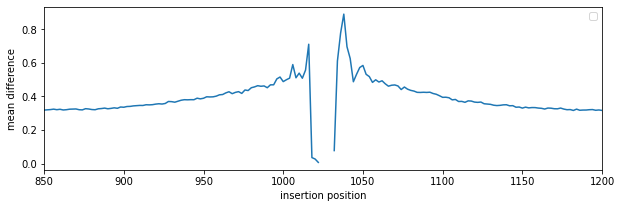

In [134]:
plt.figure(figsize=[10,3])
sns.lineplot(data=dist_dfs[dist_dfs['cell line']=='PC-3'], x='insertion position', y='mean difference')
plt.legend(bbox_to_anchor=(1,1))

plt.xlim(850, 1200)

In [112]:
df.head(20)

,motif 2,mean difference,cell line,motif 1,insertion position
0,GGTGAGTCACC_0,-0.007004,GM21381,CGGATAAGC_1024,0
1,GGTGAGTCACC_0,0.026200,GM23338,CGGATAAGC_1024,0
2,GGTGAGTCACC_0,0.011797,HepG2,CGGATAAGC_1024,0
3,GGTGAGTCACC_0,0.006172,RWPE2,CGGATAAGC_1024,0
4,GGTGAGTCACC_0,-0.005273,HG03575,CGGATAAGC_1024,0
5,GGTGAGTCACC_0,0.010106,K562,CGGATAAGC_1024,0
6,GGTGAGTCACC_0,0.000103,DND-41,CGGATAAGC_1024,0
7,GGTGAGTCACC_0,-0.010992,GM12878,CGGATAAGC_1024,0
8,GGTGAGTCACC_0,0.008513,A549,CGGATAAGC_1024,0
9,GGTGAGTCACC_0,0.007190,HCT116,CGGATAAGC_1024,0
